In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import random
import math

from pathlib import Path

import sys, site
sys.path.insert(0, site.getsitepackages()[0])
import wandb
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count


In [ ]:
# Testing-Wandb
import os
import wandb

os.environ["WANDB_API_KEY"] = "4c3fbd210d986d0a1d09d50e3e0af6ff012c590c"
# Start a new wandb run to track this script.

run = wandb.init(
    entity="basmaa2003-cairo-university",
    project="my-awesome-project",
    config={
        "learning_rate": 0.02,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "epochs": 10,
    },
)

epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2**-epoch - random.random() / epoch - offset
    loss = 2**-epoch + random.random() / epoch + offset
    run.log({"acc": acc, "loss": loss})

run.finish()

wandb: Currently logged in as: basmaa2003 (basmaa2003-cairo-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
video_dir = Path("videos-DDQN")
video_dir.mkdir(parents=True, exist_ok=True)

def should_record(episode_id: int) -> bool:
    return episode_id == 0 or (episode_id + 1) % 50 == 0

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder=str(video_dir),
    episode_trigger=should_record,
    name_prefix="cartpole-training",
)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

c:\Users\salma\anaconda3\Lib\site-packages\gymnasium\wrappers\rendering.py:434: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
c:\Users\salma\anaconda3\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\salma\Desktop\RL\RL_Assignment2\videos-DDQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [4]:
class QNetwork(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [5]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 2000
TAU = 0.005
LR = 3e-4

n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = QNetwork(n_observations, n_actions).to(device)
target_net = QNetwork(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(20000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []


def plot_durations(show_result: bool = False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    if non_final_mask.any():
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    else:
        non_final_next_states = torch.empty((0, state_batch.size(-1)), dtype=state_batch.dtype, device=state_batch.device)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    if non_final_next_states.size(0) > 0:
        with torch.no_grad():
            next_state_policy_actions = policy_net(non_final_next_states).argmax(1, keepdim=True)
            target_q_values = target_net(non_final_next_states).gather(1, next_state_policy_actions).squeeze(1)
        next_state_values[non_final_mask] = target_q_values

    expected_state_action_values = reward_batch + (next_state_values * GAMMA)

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Solved CartPole after 266 episodes! Average length over last 100: 477.8
Training complete – environment solved.


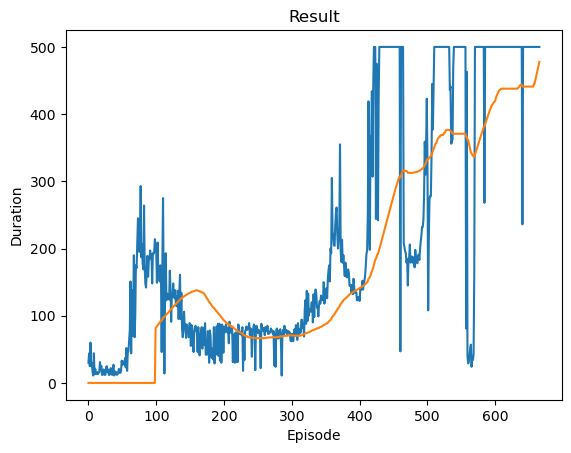

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 700

SOLVE_WINDOW = 100
SOLVE_SCORE = 475
best_average = 0.0
solved = False

for i_episode in range(num_episodes):
    state, info = env.reset(seed=seed + i_episode)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward_tensor = torch.tensor([reward], device=device)
        done = terminated or truncated

        next_state = None if done else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward_tensor)
        state = next_state

        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_length = t + 1
            episode_durations.append(episode_length)
            plot_durations()
            recent_avg = np.mean(episode_durations[-SOLVE_WINDOW:]) if len(episode_durations) >= SOLVE_WINDOW else np.mean(episode_durations)
            best_average = max(best_average, recent_avg)
            if (i_episode + 1) % 10 == 0:
                print(f"Episode {i_episode + 1}: length={episode_length}, avg={recent_avg:.1f}")
            if len(episode_durations) >= SOLVE_WINDOW and recent_avg >= SOLVE_SCORE:
                print(f"Solved CartPole after {i_episode + 1} episodes! Average length over last {SOLVE_WINDOW}: {recent_avg:.1f}")
                solved = True
            break
    if solved:
        break

if not solved:
    print(f"Stopped after {len(episode_durations)} episodes. Best average length: {best_average:.1f}")
else:
    print("Training complete – environment solved.")

plot_durations(show_result=True)
plt.ioff()
plt.show()
env.close()

In [9]:
import base64
from IPython.display import HTML

def show_latest_video(video_directory: Path = video_dir) -> HTML:
    video_files = sorted(video_directory.glob("*.mp4"))
    if not video_files:
        raise FileNotFoundError("No recorded CartPole episodes yet.")
    latest_video = video_files[-1]
    video_b64 = base64.b64encode(latest_video.read_bytes()).decode("ascii")
    return HTML(
        f'<video width="640" controls>'
        f'<source src="data:video/mp4;base64,{video_b64}" type="video/mp4" />'
        "Your browser does not support the video tag."
        "</video>"
)

show_latest_video()